# Create maps of The Caribbean islands from shape files

This map is created from multiple shape files for multiple caribbean islands around the Caribbean meteor in order to get maps of the event, the stations used and the propagation of the perturbations.
Source: [Geominds](http://www.geominds.de/descargas.html)

## Test with Cuba

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
from plotfullmap import plot_map
import argparse
from astropy.table import Table
import glob
import matplotlib.cm as cm
from scipy.interpolate import griddata
from midpoint import MidpointNormalize
import datetime

In [2]:
sns.set_style("whitegrid") 
sns.mpl.rc("figure", figsize=(10,6))

(-85.493106455, -73.590654245, 19.638531765, 23.772268735)

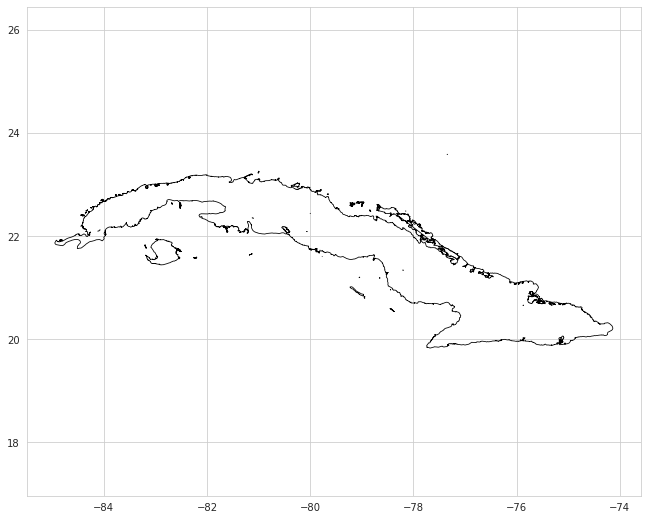

In [3]:
sf = shp.Reader("./Map/Cuba.shp")
plot_map(sf)
plt.axis("equal")

## Do the caribbean zone map where the meteor was located

(-85.947535495, -64.047644405, 17.606227575000002, 23.869045125)

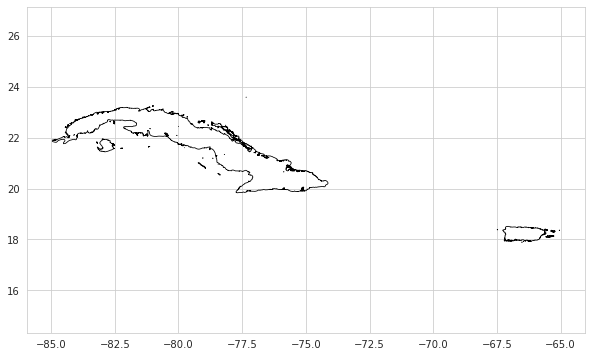

In [4]:
cuba = shp.Reader("./Map/Cuba.shp")
#plot_map(cuba)
#jamaica = shp.Reader("./Map/Jamaica.shp")
PRico = shp.Reader("./Map/coastline.shp")
#plot_map(PRico)
PR2 = shp.Reader("./Map/islands.shp")
#plot_map(PR2)
for sf in [cuba, PRico, PR2]:
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, "k", lw=0.8)
plt.axis("equal")

Clearly our older function only works for individual shape files. We need to improvise another new function that cover all the caribbean region. Let's try with the glob library. It may work !!!

First we need to enlist all the shapefiles we need in order to cover the whole region

- [X] Cuba
- [ ] Jamaica
- [X] Haití
- [X] República Dominicana
- [X] Puerto Rico
- [X] Islas Virgenes Británicas
- [X] Montserrat
- [X] Guadalupe
- [X] Dominica
- [X] Martinica
- [X] Santa Lucía
- [X] Barbados
- [X] San Vicente y las Granadinas
- [X] Granada
- [X] Trinidad y Tobago
- [X] Anguilla
- [X] San Cristóbal y Nieves
- [X] Antigua y Barbuda
- [X] Colombia
- [X] Venezuela
- [X] Aruba

(0.0, 30.0)

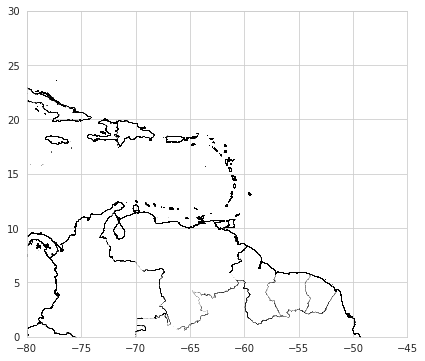

In [5]:
caribe = glob.glob("./Map/*.shp")
for car in caribe:
    sf = shp.Reader(car)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, "k.", ms=0.025)
plt.gca().set_aspect("equal")
plt.xlim(-80, -45)
plt.ylim(0, 30)

## Estimate meteor trajectory just before fragmentation

Based on data available at [https://cneos.jpl.nasa.gov/fireballs/](https://cneos.jpl.nasa.gov/fireballs/), we find the following information about the meteor paramenters:
- Date and time of fragmentation: 2019-06-22 (2019 June 22th) 21:25:48 UT
- Latitude and Longitude: 14.9, -66.2
- Altitude: 25.0 km
- Velocity: 14.9 km/s
- Velocity components: $v_x = -13.4$, $v_y=6.0$, $v_z = 2.5$
  where $v_x$ is the velocity along the equatorial plane towards the prime meridian, $v_z$ is the velocity along the earth's    rotation axis, towards the north celestial pole and $v_y$ complets the right handed coordinate system
- Total radiated energy: $2.8 \times 10^{10}~J$
- Calculated total impact energy: 6 kt

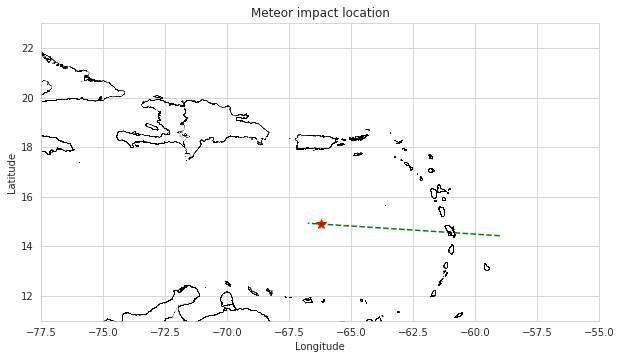

In [40]:
y_lat, x_lon = np.array((14.9)), np.array((-66.2))
v_eq = np.array((-13.4))
v_lat = np.array((2.5*np.cos(np.radians(y_lat))- 6.0*np.sin(np.radians(y_lat))))
re, h = 6371, 25
t = np.linspace(-60., 4.5)
xm, ym = np.degrees(v_eq/(re+h)*t)+x_lon, np.degrees(v_lat/(re+h)*t)+y_lat
plt.plot(x_lon, y_lat, "r*", ms=10)
plt.plot(xm, ym, "g--", label="Estimated bolide trajectory")
#plt.quiver(x_lon, y_lat, v_eq/7, v_lat/7, units="xy", scale=1, color="blue")
for car in caribe:
    sf = shp.Reader(car)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, "k.", ms=0.025)
plt.gca().set_aspect("equal")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Meteor impact location")
plt.xlim(-77.5, -55)
plt.ylim(11, 23)
plt.savefig("./paper/figures/meteor_location_map.pdf")

Venezuela, Jamaica, Antigua and Barbuda and Colombia shapefiles:
[https://gadm.org/index.html](https://gadm.org/index.html)

### Map with stations

Now it's time to do a map with the location of all stations used to get GPS data

### Incorporate GLM data

In [38]:
GLM_data = pd.read_csv("./data/2019-06-22/GLM16-data.csv", header = 9)
Lat, Lon = GLM_data["latitude"], GLM_data["longitude"]
GLM_data.head(5)

,time (ms),longitude,latitude,energy (joules)
0,1561238745265,-65.776215,14.906006,1.525970e-15
1,1561238745468,-65.807884,14.905684,4.577910e-15
2,1561238745470,-65.810646,14.905668,3.051940e-15
3,1561238745472,-65.811707,14.905637,4.577910e-15
4,1561238745474,-65.822113,14.905485,4.577910e-15


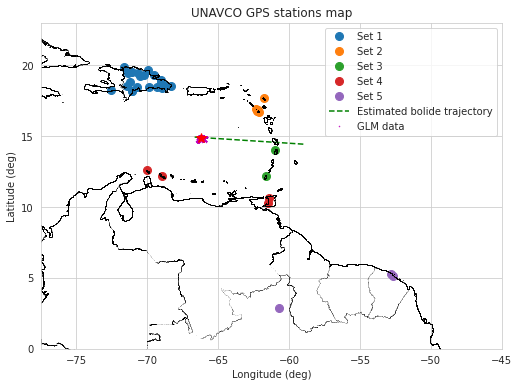

In [41]:
stations_lat1 = [18.21, 18.56, 19.67, 18.41, 18.76, 18.23, 19.22, 18.45, 19.45, 18.60, 19.31, 19.54, 19.85, 18.98, 18.50, 18.46, 19.29, 18.82, 18.46, 19.48, 18.21]
stations_lon1 = [-71.09, -68.35, -69.93, -68.93, -69.04, -72.54, -70.53, -70.72, -70.68, -68.72, -69.55, -71.08, -71.64, -69.04, -71.42, -69.91, -70.25, -71.23, -69.31, -71.34, -71.10]
stations_lat2 = [16.74, 17.67, 16.80, 16.82, 16.75, 16.70, 16.93, 16.76]
stations_lon2 = [-62.21, -61.79, -62.19, -62.20, -62.23, -62.15, -62.35, -62.16]
stations_lat3 = [14.02, 12.22]
stations_lon3 = [-60.97, -61.64]
stations_lat4 = [12.61, 12.18, 10.28, 10.64]
stations_lon4 = [-70.04, -68.96, -61.47, -61.40]
stations_lat5 = [2.85, 5.10, 5.25]
stations_lon5 = [-60.70, -52.64, -52.81]
plt.plot(stations_lon1, stations_lat1, "o", ms=8, label="Set 1")
plt.plot(stations_lon2, stations_lat2, "o", ms=8, label="Set 2")
plt.plot(stations_lon3, stations_lat3, "o", ms=8, label="Set 3")
plt.plot(stations_lon4, stations_lat4, "o", ms=8, label="Set 4")
plt.plot(stations_lon5, stations_lat5, "o", ms=8, label="Set 5")
plt.plot(xm, ym, "g--", label="Estimated bolide trajectory")
plt.plot(Lon, Lat, "m.", ms=1, label = "GLM data")
plt.plot(x_lon, y_lat, "r*", ms=10)
#plt.quiver(x_lon, y_lat, v_eq/7, v_lat/7, units="xy", scale=1, color="blue")
for car in caribe:
    sf = shp.Reader(car)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, "k.", ms=0.025)
plt.legend()
plt.gca().set_aspect("equal")
plt.xlabel("Longitude (deg)")
plt.ylabel("Latitude (deg)")
plt.title("UNAVCO GPS stations map")
plt.xlim(-77.5, -45)
plt.ylim(0, 23)
plt.savefig("./paper/figures/caribbean_stations_map.png")

## Map with sTEC data

Now we will include data from sTEC collected by the UNAVCO GPS stations, we will use the cubic interpolation method with the time series we already have and superimpose the current map.

### Read data of the 5 sets of stations

In [8]:
set1 = pd.read_csv("./data/2019-06-22/set1/2019-06-22_21.43_detrended-sTEC.csv")
set2 = pd.read_csv("./data/2019-06-22/set2/2019-06-22_21.43_detrended-sTEC.csv")
set3 = pd.read_csv("./data/2019-06-22/set3/2019-06-22_21.43_detrended-sTEC.csv")
set4 = pd.read_csv("./data/2019-06-22/set4/2019-06-22_21.43_detrended-sTEC.csv")
set5 = pd.read_csv("./data/2019-06-22/set5/2019-06-22_21.43_detrended-sTEC.csv")

### Extract also next day data from set 1

In [9]:
next_set = pd.read_csv("./data/2019-06-22/set1/next/next2019-06-22_21.43_detrended-sTEC.csv")

### Extract and merge relevant data

In [10]:
lat1 = np.array(set1["Latitude"])
lat2 = np.array(set2["Latitude"])
lat3 = np.array(set3["Latitude"])
lat4 = np.array(set4["Latitude"])
lat5 = np.array(set5["Latitude"])
lat_next = np.array(next_set["Latitude"])
latitude = np.concatenate((lat1, lat_next, lat2, lat3, lat4, lat5))

In [11]:
lon1 = np.array(set1["Longitude"])
lon2 = np.array(set2["Longitude"])
lon3 = np.array(set3["Longitude"])
lon4 = np.array(set4["Longitude"])
lon5 = np.array(set5["Longitude"])
lon_next = np.array(next_set["Longitude"])
longitude = np.concatenate((lon1, lon_next, lon2, lon3, lon4, lon5))

In [12]:
tec1 = np.array(set1["sTEC"])
tec2 = np.array(set2["sTEC"])
tec3 = np.array(set3["sTEC"])
tec4 = np.array(set4["sTEC"])
tec5 = np.array(set5["sTEC"])
tec_next = np.array(next_set["sTEC"])
TEC = np.concatenate((tec1, tec_next,tec2, tec3, tec4, tec5))

### Create the map

Set map boundaries and create grid

In [13]:
xmin, ymin = np.min(longitude), np.min(latitude)
xmax, ymax = np.max(longitude), np.max(latitude) 
res = 0.1
nx = int((xmax-xmin)/res)*1j
ny = int((ymax-ymin)/res)*1j

In [14]:
grid_x, grid_y = np.mgrid[xmin:xmax:nx, ymin:ymax:ny]

Create coordinates array

In [15]:
coordinates = []
for lat, lon in zip(latitude, longitude):
    coord_pair = [lon, lat]
    coordinates.append(coord_pair)

/tmp/ipykernel_9756/1481031816.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar =plt.colorbar()


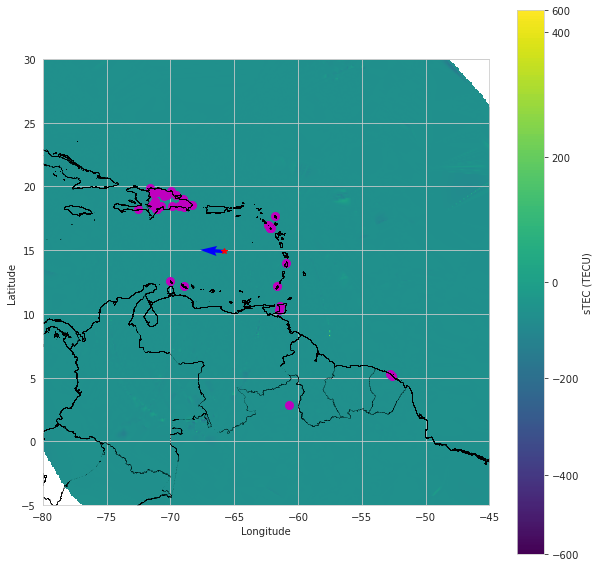

In [16]:
meteor_pos_x, meteor_pos_y = -65.8, 14.9
grid0 = griddata(np.array(coordinates), TEC, (grid_x, grid_y), method="cubic")
norm = MidpointNormalize(midpoint=0)
plt.imshow(grid0.T, extent=(xmin, xmax, ymin, ymax), origin="lower", cmap="viridis", norm=norm)
plt.plot(meteor_pos_x, meteor_pos_y, "r*")
cbar =plt.colorbar()
cbar.set_label("sTEC (TECU)")
plt.plot(stations_lon, stations_lat, "mo", ms=8)
#plt.plot(lon, lat, "r*", ms=10)
plt.quiver(meteor_pos_x, meteor_pos_y, v_eq/7, v_lat/7, units="xy", scale=1, color="blue")
for car in caribe:
    sf = shp.Reader(car)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, "k.", ms=0.025)
plt.gca().set_aspect("equal")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim(-80, -45)
plt.ylim(-5, 30)
plt.gcf().set_size_inches(10, 10)

## Zooming regions of interest

The possible perturbations may be located at $latitude\sim 0$, $longitude \sim -68$ and $latitude \sim 20$, $longitude \sim -56$. Let's zoom the surroundings of these regions

/tmp/ipykernel_9756/752774051.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar =plt.colorbar()


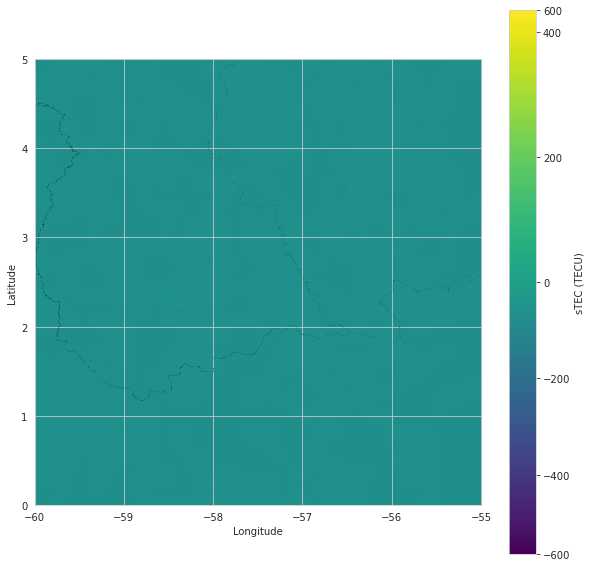

In [17]:
meteor_pos_x, meteor_pos_y = -65.8, 14.9
grid0 = griddata(np.array(coordinates), TEC, (grid_x, grid_y), method="cubic")
norm = MidpointNormalize(midpoint=0)
plt.imshow(grid0.T, extent=(xmin, xmax, ymin, ymax), origin="lower", cmap="viridis", norm=norm)
plt.plot(meteor_pos_x, meteor_pos_y, "r*")
cbar =plt.colorbar()
cbar.set_label("sTEC (TECU)")
plt.plot(stations_lon, stations_lat, "mo", ms=8)
#plt.plot(lon, lat, "r*", ms=10)
plt.quiver(meteor_pos_x, meteor_pos_y, v_eq/7, v_lat/7, units="xy", scale=1, color="blue")
for car in caribe:
    sf = shp.Reader(car)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, "k.", ms=0.025)
plt.gca().set_aspect("equal")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim(-60, -55)
plt.ylim(0, 5)
plt.gcf().set_size_inches(10, 10)

/tmp/ipykernel_9756/506063367.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar =plt.colorbar()


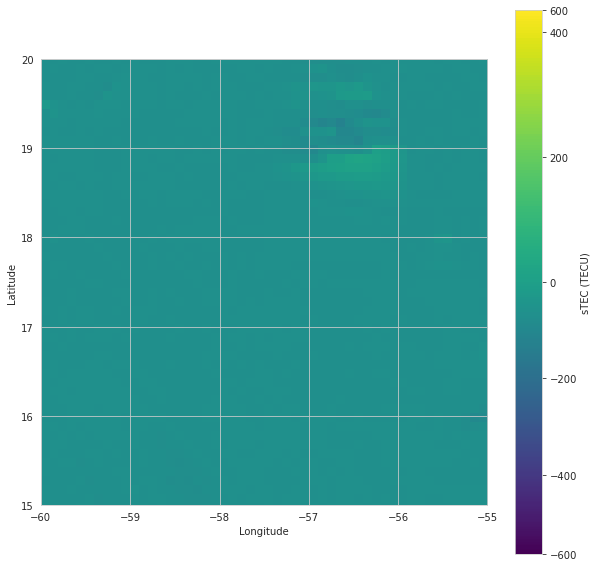

In [18]:
meteor_pos_x, meteor_pos_y = -65.8, 14.9
grid0 = griddata(np.array(coordinates), TEC, (grid_x, grid_y), method="cubic")
norm = MidpointNormalize(midpoint=0)
plt.imshow(grid0.T, extent=(xmin, xmax, ymin, ymax), origin="lower", cmap="viridis", norm=norm)
plt.plot(meteor_pos_x, meteor_pos_y, "r*")
cbar =plt.colorbar()
cbar.set_label("sTEC (TECU)")
plt.plot(stations_lon, stations_lat, "mo", ms=8)
#plt.plot(lon, lat, "r*", ms=10)
plt.quiver(meteor_pos_x, meteor_pos_y, v_eq/7, v_lat/7, units="xy", scale=1, color="blue")
for car in caribe:
    sf = shp.Reader(car)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, "k.", ms=0.025)
plt.gca().set_aspect("equal")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim(-60, -55)
plt.ylim(15, 20)
plt.gcf().set_size_inches(10, 10)

/tmp/ipykernel_9756/1481031816.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar =plt.colorbar()


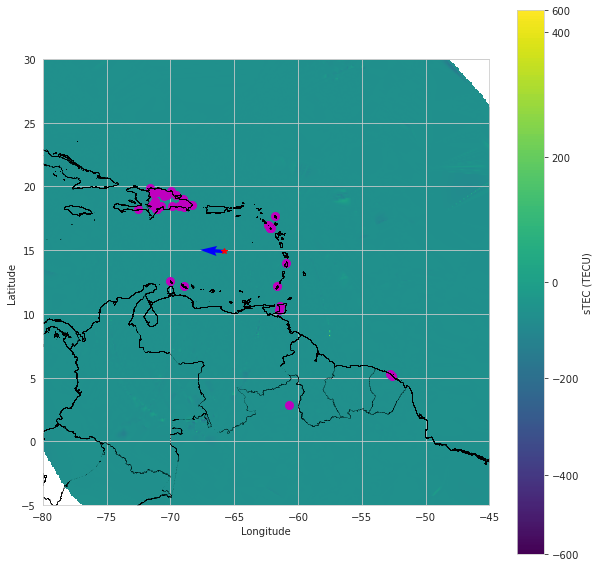

In [19]:
meteor_pos_x, meteor_pos_y = -65.8, 14.9
grid0 = griddata(np.array(coordinates), TEC, (grid_x, grid_y), method="cubic")
norm = MidpointNormalize(midpoint=0)
plt.imshow(grid0.T, extent=(xmin, xmax, ymin, ymax), origin="lower", cmap="viridis", norm=norm)
plt.plot(meteor_pos_x, meteor_pos_y, "r*")
cbar =plt.colorbar()
cbar.set_label("sTEC (TECU)")
plt.plot(stations_lon, stations_lat, "mo", ms=8)
#plt.plot(lon, lat, "r*", ms=10)
plt.quiver(meteor_pos_x, meteor_pos_y, v_eq/7, v_lat/7, units="xy", scale=1, color="blue")
for car in caribe:
    sf = shp.Reader(car)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, "k.", ms=0.025)
plt.gca().set_aspect("equal")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim(-80, -45)
plt.ylim(-5, 30)
plt.gcf().set_size_inches(10, 10)

 ## Search for areas where TIDs could be in our map

We expect TIDs propagate radially from bolide location at a fixed? speed. If that's true, we can mark in the map the areas where TIDs should be after a certain time.
According to the paper introduction, Medium scale TIDs have velocities between 50 and 100 km/s, so we can trace circles  with radii $r = vt$ where $t$ is the duration of our time windows. Let's see what happens.

The axis of the map are latitude and longitude, to convert from distance to degrees we must divide by the earth radius + bolide altitude and convert to degrees.

At 50 km/s, TIDs complete a turn around Earth in about 13 minutes !!! This isn' the kind of TIDs we are looking for. For Chelyabinsk meteor, there was found three type of TIDs: high frequency at $\sim 900~m/s$, a second type at $\sim 360~m/s$ and a third type with a shorter period at a speed of $\sim 730~m/s$

In [20]:
40000/50/60

13.333333333333334

In [21]:
v_TID_low = 900/1000.
v_TID_med = 730/1000.
v_TID_high = 360/1000.
delta_t = 3600*np.array([1, 2, 3])
r_circ1 = v_TID_low*delta_t
r_circ2 = v_TID_high*delta_t
r_circ3 = v_TID_med*delta_t
Re = 6371
mh = 25
R1 = np.degrees(r_circ1/(Re+mh))
R2 = np.degrees(r_circ2/(Re+mh))
R3 = np.degrees(r_circ3/(Re+mh))

(0.0, 23.0)

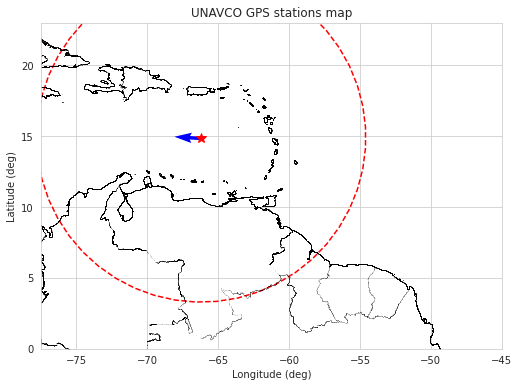

In [22]:
plt.plot(x_lon, y_lat, "r*", ms=10)
plt.quiver(x_lon, y_lat, v_eq/7, v_lat/7, units="xy", scale=1, color="blue")
plt.plot(R2[0]*np.cos(np.linspace(-np.pi, np.pi))+x_lon, R2[0]*np.sin(np.linspace(-np.pi, np.pi))+y_lat, "r--")
for car in caribe:
    sf = shp.Reader(car)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, "k.", ms=0.025)
plt.gca().set_aspect("equal")
plt.xlabel("Longitude (deg)")
plt.ylabel("Latitude (deg)")
plt.title("UNAVCO GPS stations map")
plt.xlim(-77.5, -45)
plt.ylim(0, 23)

TIDs with a velocity of about 360 m/s may be detectable in the first hour after the event, and this kind of TID was detected in the Chelyabinsk event. For this event TIDs with lower speeds are plausible

## Check only set 5 data

Set 5 is one of the few ones capabable of find TIDs, and maybe after considering all the non successful sTEC data the real TIDs found by those few successful stations are being eclipsed.

In [23]:
PRN_mask = set5["PRN"] ==7
station_mask = set5["Station"] == "boav"
tec5_masked = tec5[~(PRN_mask & station_mask)]

In [24]:
xmin5, ymin5 = np.min(lon5[~(PRN_mask & station_mask)]), np.min(lat5[~(PRN_mask & station_mask)])
xmax5, ymax5 = np.max(lon5[~(PRN_mask & station_mask)]), np.max(lat5[~(PRN_mask & station_mask)])
res = 0.1
nx = int((xmax-xmin)/res)*1j
ny = int((ymax-ymin)/res)*1j

In [25]:
grid_x, grid_y = np.mgrid[xmin:xmax:nx, ymin:ymax:ny]

In [26]:
coordinates = []
for lat, lon in zip(lat5[~(PRN_mask & station_mask)], lon5[~(PRN_mask & station_mask)]):
    coord_pair = [lon, lat]
    coordinates.append(coord_pair)

/tmp/ipykernel_9756/795819545.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar =plt.colorbar()


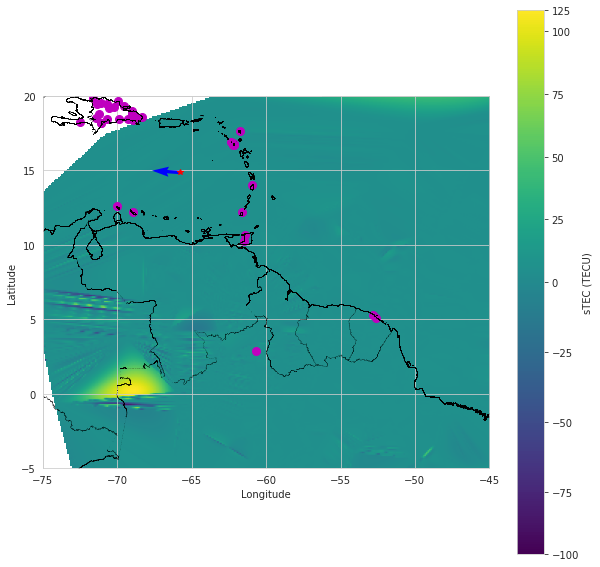

In [27]:
meteor_pos_x, meteor_pos_y = -65.8, 14.9
grid5 = griddata(np.array(coordinates), tec5_masked, (grid_x, grid_y), method="cubic")
norm = MidpointNormalize(midpoint=0)
plt.imshow(grid5.T, extent=(xmin, xmax, ymin, ymax), origin="lower", cmap="viridis", norm=norm)
plt.plot(meteor_pos_x, meteor_pos_y, "r*")
cbar =plt.colorbar()
cbar.set_label("sTEC (TECU)")
plt.plot(stations_lon, stations_lat, "mo", ms=8)
#plt.plot(lon, lat, "r*", ms=10)
plt.quiver(meteor_pos_x, meteor_pos_y, v_eq/7, v_lat/7, units="xy", scale=1, color="blue")
for car in caribe:
    sf = shp.Reader(car)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, "k.", ms=0.025)
plt.gca().set_aspect("equal")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim(-75, -45)
plt.ylim(-5, 20)
plt.gcf().set_size_inches(10, 10)

## Add the satellites trajectories

First we will not add the sTEC maps but include satellites trajectories (and the point where BOAV station began to detect TIDs) and BOAV station position.

In [28]:
s_data = pd.read_csv("set5_TID_detection.csv")
f = open("./data/2019-06-22/set4/cn19173-2019-06-22.Cmn", "r")
for i in range(4):
    f.readline()
raw_data = f.readlines()
cmn_data = Table.read(raw_data, format="ascii")
s_lats, s_lons = cmn_data["Lat"], cmn_data["Lon"]-360.
time = cmn_data["Time"]
starttime = 21. + 25/60. +48./3600.
time_window = (time> max(starttime-2.5, 0.0)) & (time< min(starttime+3.5, 24.0))
prn_list = [2, 5, 6, 9, 12, 13, 17, 19]
prn_text_coords_x= [-72, -74.5, -62.5, -62, -74, -70, -64.9, -68]
prn_text_coords_y= [17, 4, 11, 19, 12, 4, 6, 7]
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]
k=0

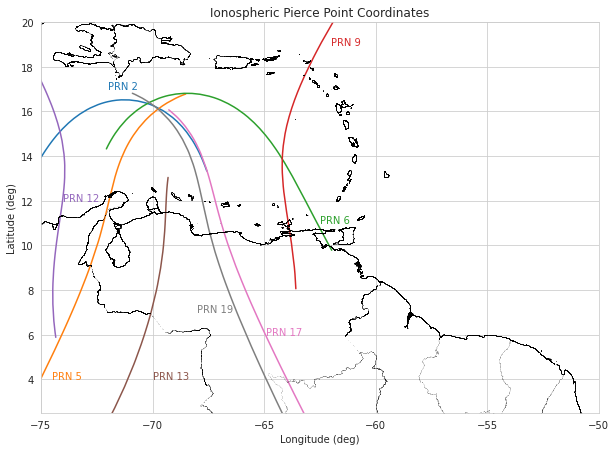

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect="equal")
for j,p in enumerate(prn_list):
    prn_mask = cmn_data["PRN"] == p
    ax.plot(s_lons[prn_mask & time_window], s_lats[prn_mask &time_window])
    ax.text(prn_text_coords_x[j], prn_text_coords_y[j], "PRN {}".format(p), c=colors[k])
    k+=1
for car in caribe:
    sf = shp.Reader(car)
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        ax.plot(x, y, "k.", ms=0.025)
ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Latitude (deg)")
ax.set_title("Ionospheric Pierce Point Coordinates")
ax.set_xlim(-75, -50)
ax.set_ylim(2.5, 20)
fig.set_size_inches(10, 10)